In [7]:
cd '/home/knight/matar/PYTHON/ECOGpy'

/home/knight/matar/PYTHON/ECOGpy


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import os
import numpy as np
import pandas as pd

from plotting.plot_singletrials import plot_singletrials
from utils.get_HGdata import get_HGdata
from ShadePlots.shadeplot_elec import calc_shadeplot, plot_shadeplot
from plotting.plot_brain import plot_clusters

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

# Clustering electrodes by temporal profiles in electrocorticography

![1cm_grid](1cm_grid.png "1 cm electrode spacing") ![4mm_grid](4mm_grid.png "4 mm spacing")

# the data
* 3051 channels of continuous time series data analyzed
* (1344 electrodes x 16 participants x 8 tasks downsampled to 1kHz)
* one dataset approx 64 x 1,400,000


![electrode coverage](coverage.png)

![rawdata](rawdata.png)

# How can we group it into meaningful clusters?

ECoG signal contains two primary components, each carrying unique information
1. low frequency oscillations (<40Hz) 
2. broadband spectral power change (70-200Hz; aka high gamma)

HG indexes local cortical activation (neuronal firing)

## epoched HG data

In [11]:
#get data
subj, task = ('GP15','EmoGen')
var_list = ['srate','data_percent','active_elecs', 'RTs'] #vars of interest
srate, alldata, active_elecs, RTs = get_HGdata(subj, task, var_list, type = 'percent')

# variables:
#    alldata = HG data matrix - elecs x trials x time
#    srate = data sampling rate
#    active_elecs = electrode indices
#    RTs = reaction times (in srate)

In [12]:
alldata.shape #elecs x trials x time

(31, 147, 4799)

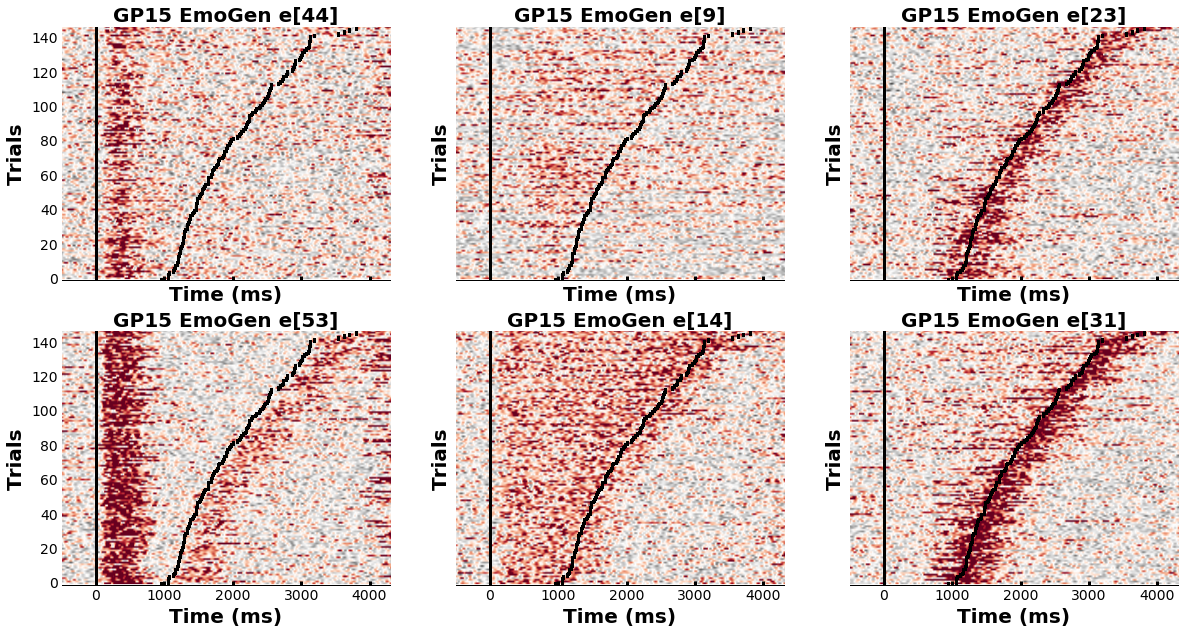

In [35]:
f, ax = plt.subplots(2, 3, sharey = True, sharex = True, figsize=(20,10))
ax = ax.flatten()

elecs = [44, 9, 23, 53, 14, 31] #some example elecs
for i, elec in enumerate(elecs):
    _ = plot_singletrials(subj, task, [elec], fig = f, ax = ax[i], cbar = False)


# temporal PCA with EFA
**See R notebook**

# Hierarchical clustering

Calculate pairwise distances between observations (using correlation)

Perform agglomerative clustering using the distance matrix.

Calculate distance using *complete linkage* 

* Complete linkage calculates the distance between farthest elements in cluster

* Leads to spherical clusters where all points are reasonably close to each other


In [14]:
#get data (elecs x components) & format
subj, task = ('GP15','EmoGen')
filename = '{0}_{1}_loadings.csv'.format(subj, task)
df = pd.read_csv(os.path.join('notebooks','demo_analysis', filename))

In [36]:
distance = pdist(df, 'correlation') #create distance matrix using correlation (condensed)
Z = hc.linkage(distance, method = 'complete') # cluster using complete linkage
# Z[:,0] and Z[:,1] are indices of merged children. Z[:,2] is distance between them; Z[:,3] is number of leaves


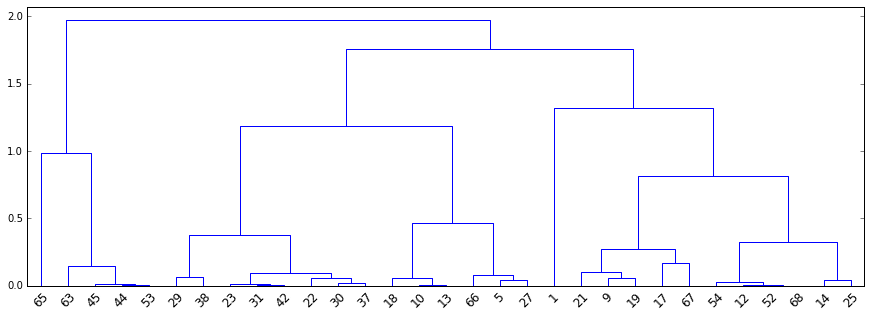

In [251]:
#plot dendrogram to see distances between elements and clusters
#dendrogram - y coordinate is the similarity of the two clusters
f, ax = plt.subplots(figsize = (15,5))
dend = hc.dendrogram(Z, labels = df.index, color_threshold=0, leaf_font_size = 12, ax = ax) 

## Decide where to split the dendrogram

Once have dendrogram can cut wherever you want and get a different number of clusters

Inconsistency method - *"what makes a jump a jump?"*
* Compares each cluster merge's height to the average and normalizes it by the standard deviation over the previous levels
* Calculated for each link of the hierarchical cluster tree. 

Inconsistent links indicate a natural division in the data
* Use the median inconsistency coefficient as the threshold to partition the data into electrode groups.

In [252]:
incon = hc.inconsistent(Z) #inconsistency
cutoff = np.median(incon[:,-1])
#cutoff = .7*max(Z[:,2]) #matlab's default (70% of maximum distance)

Cluster using `distance` criterion
* Cophenetic distance between members of each cluster is less than `cutoff` (defined as median inconsistency)
* Cophentic distance 
 * the height of the dendrogram where the 2 branches that include the elements merge together
 * aka distance between objects is the distance between their clusters at the time of these clusters' merge

In [253]:
cluster = hc.fcluster(Z, cutoff, criterion = 'distance')

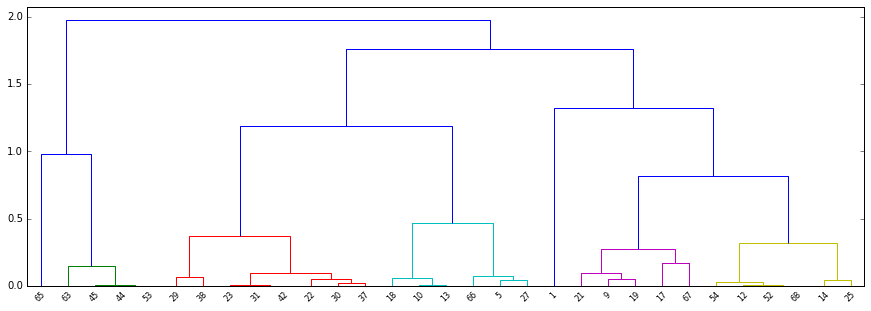

In [254]:
#replot dendrogram with colors per cluster
f, ax = plt.subplots(figsize = (15,5))
dend = hc.dendrogram(Z, labels = df.index, color_threshold=cutoff, ax = ax)

In [257]:
#dataframe with cluster designation per electrode
groupidx = pd.DataFrame(cluster, index = df.index, columns = ['cluster'])
groupidx.head()

cluster
1         7
5         4
9         5
10        4
12        6

## Brain plots

In [258]:
recon_path = '/home/knight/matar/MATLAB/DATA/Avgusta/Subjs/GP15/GP15_Lateral_Left_blankelecs.png'
xycoord_path = '/home/knight/matar/MATLAB/DATA/Avgusta/Subjs/GP15/xycoords.p'

In [264]:
groupidx = groupidx.drop([65, 66, 67, 68]) #not on recon

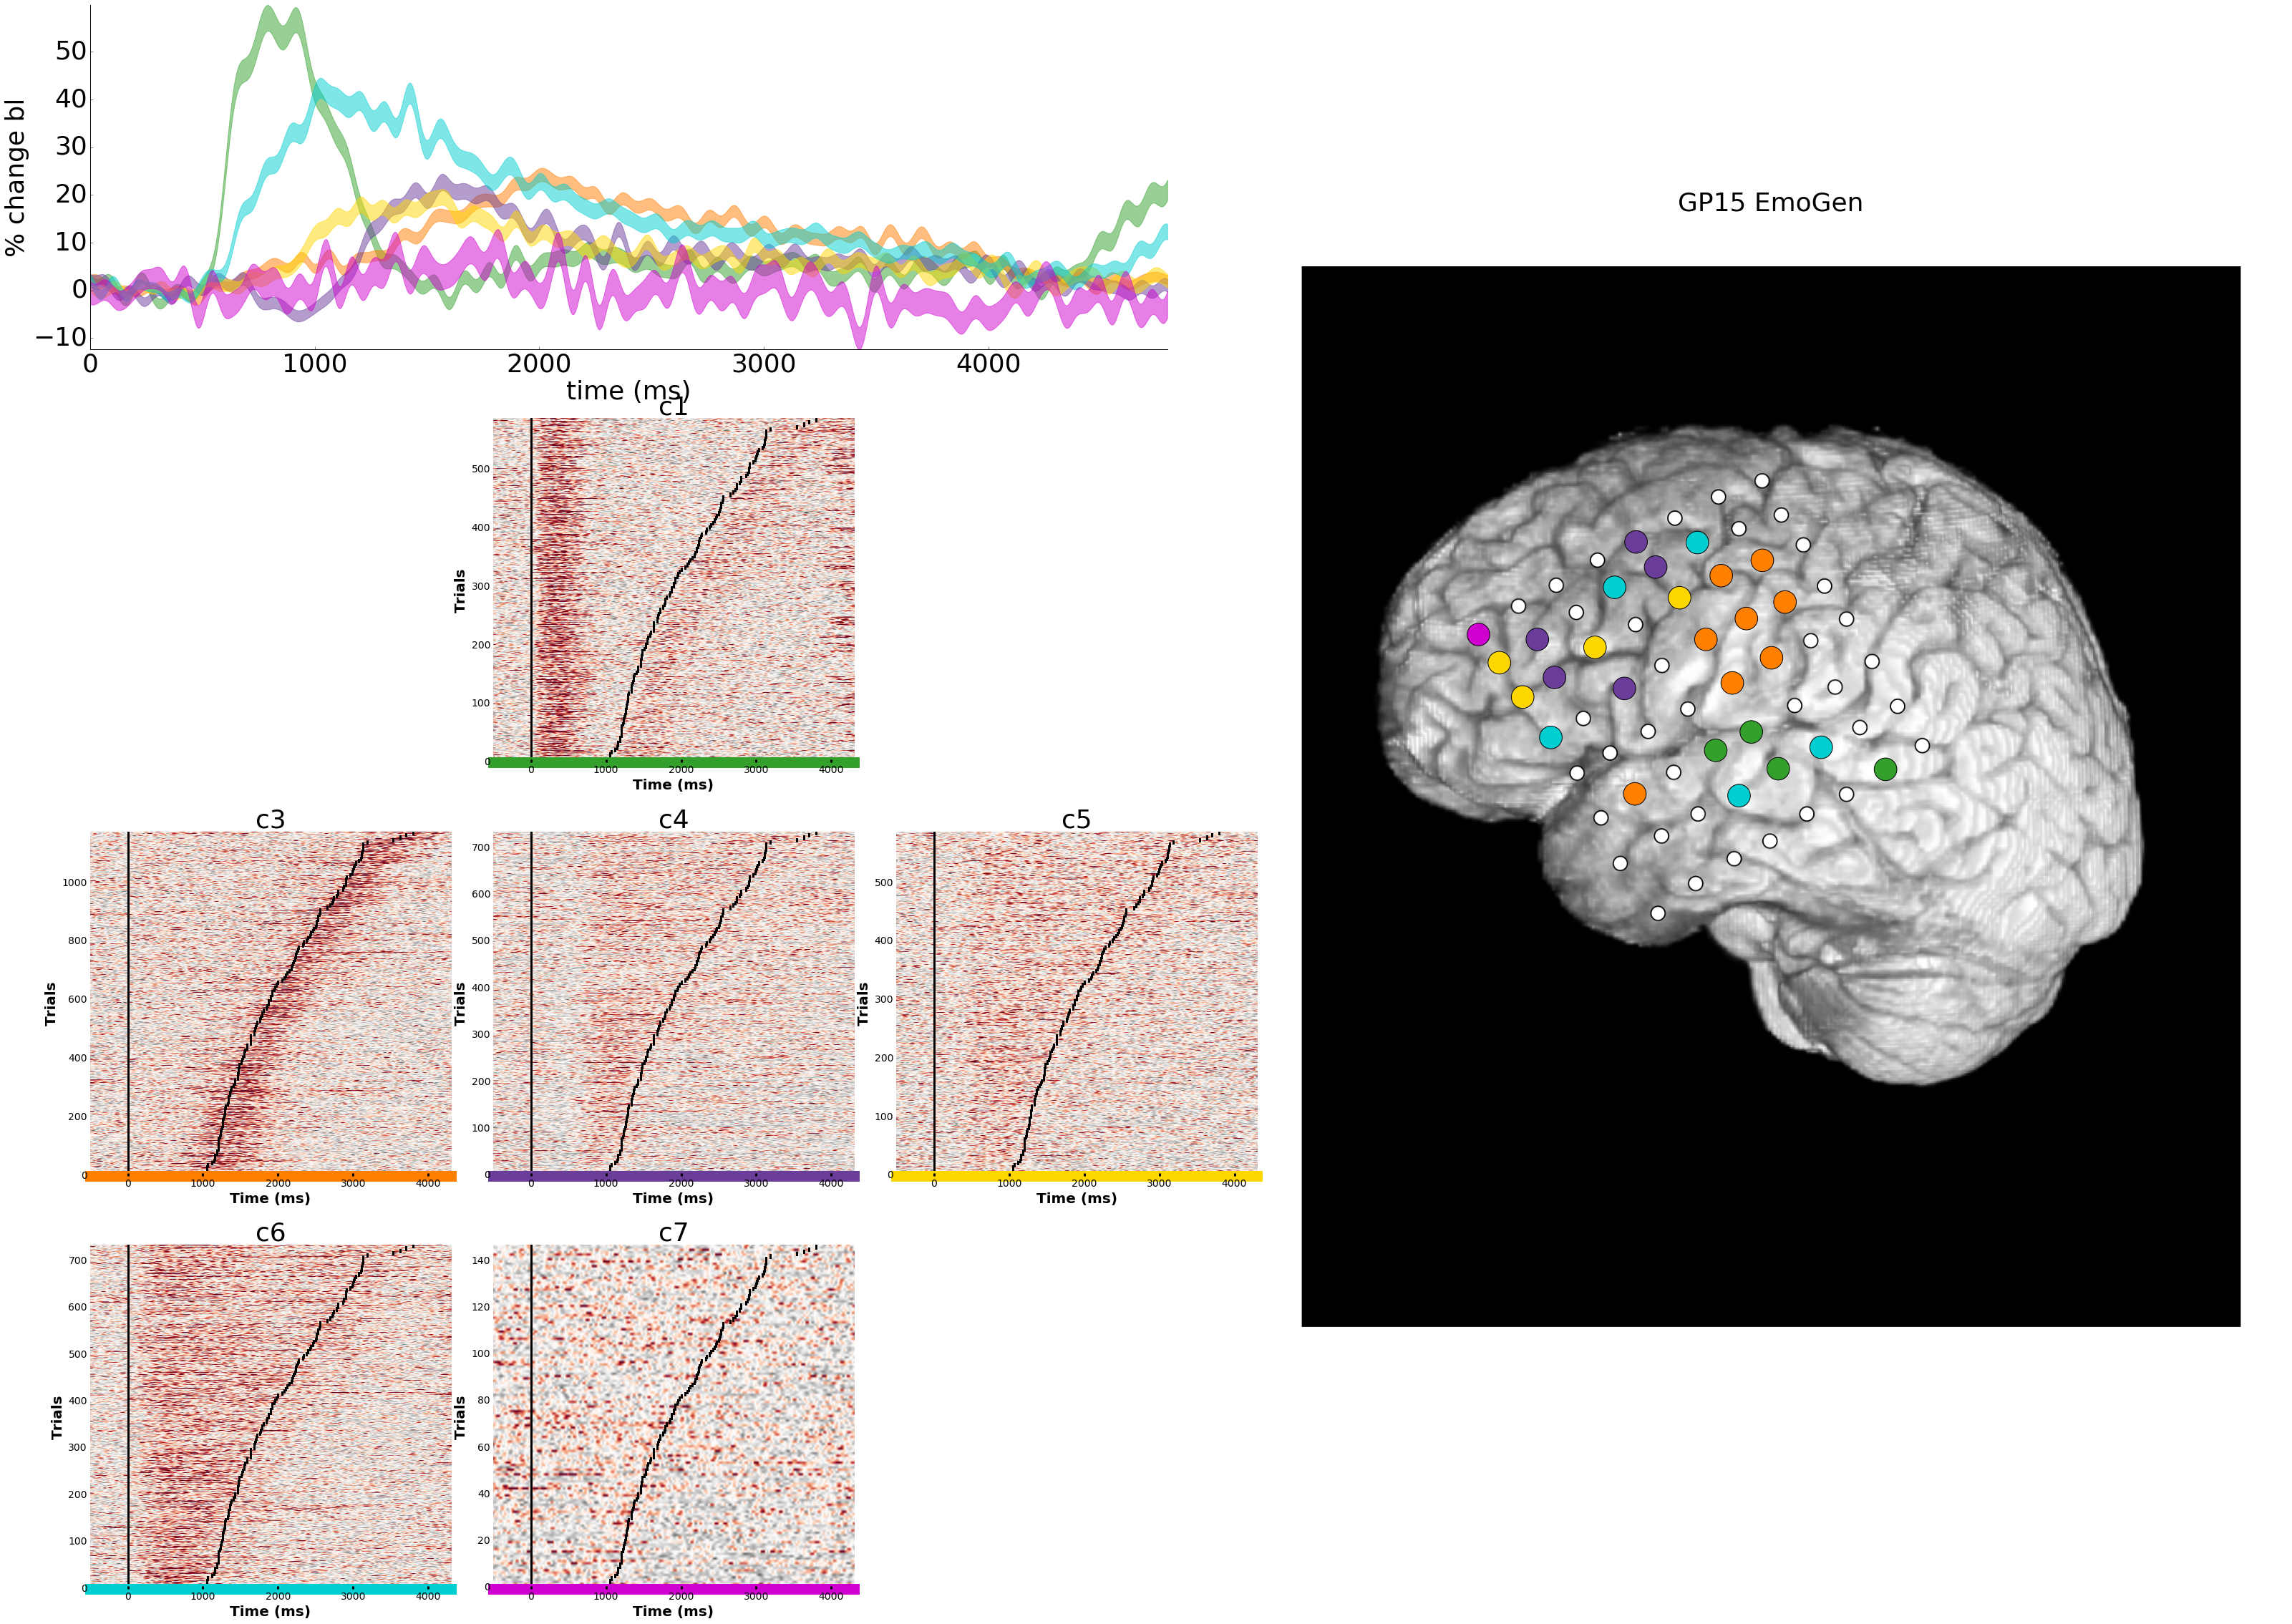

In [276]:
plot_clusters(subj, task, recon_path, xycoord_path, groupidx)

## Aggregating across all datasets...

![patterns](patterns.png "grouped by temporal profile") 